In [348]:

import pickle
import matplotlib.pyplot as plt
import torch
import io, math
import numpy as np
import os
import xarray as xr

from s2aenso.utils import data, normalization, metric
from s2aenso.utils.utilities import *

PATH = "C:/Users/felix/PycharmProjects/deeps2a-enso/scripts/evaluation/results/"


model_num_swin = 769026
model_num_vit = 768663
model = "both"

run_specification_vit = "sst_var_scale"
run_specification_swin = "sst_baseline"
dataset = "oras5" # "cesm2_picontrol" or "oras5" or "cesm2_lens"


if model != "both":
    model_num = model_num_vit if model == "vit" else model_num_swin
    save_dir = PATH + f"processed/{dataset}/processed_results_{model}_{model_num}_{run_specification_vit}/"
else:
    save_dir = PATH + f"processed/{dataset}/processed_results_vit{model_num_vit}_swin{model_num_swin}_{run_specification_vit}/"

create_directory(save_dir)

# Load swinlstm results from pickle file
with open(PATH + f'unprocessed/{dataset}/results_swinlstm_{model_num_swin}_{run_specification_swin}.pkl', 'rb') as file:   
    data_swinlstm = CPU_Unpickler(file).load()


# Load vit results from pickle file
with open(PATH + f'unprocessed/{dataset}/results_vit_{model_num_vit}_{run_specification_vit}.pkl', 'rb') as file:
    data_vit = CPU_Unpickler(file).load()


def calculate_mean_std(loss_dict, metric):
    all_values = [loss_dict[subsample][metric] for subsample in loss_dict if 'total' not in subsample]
    mean_values = np.mean(all_values, axis=0)
    std_values = np.std(all_values, axis=0)
    return mean_values, std_values

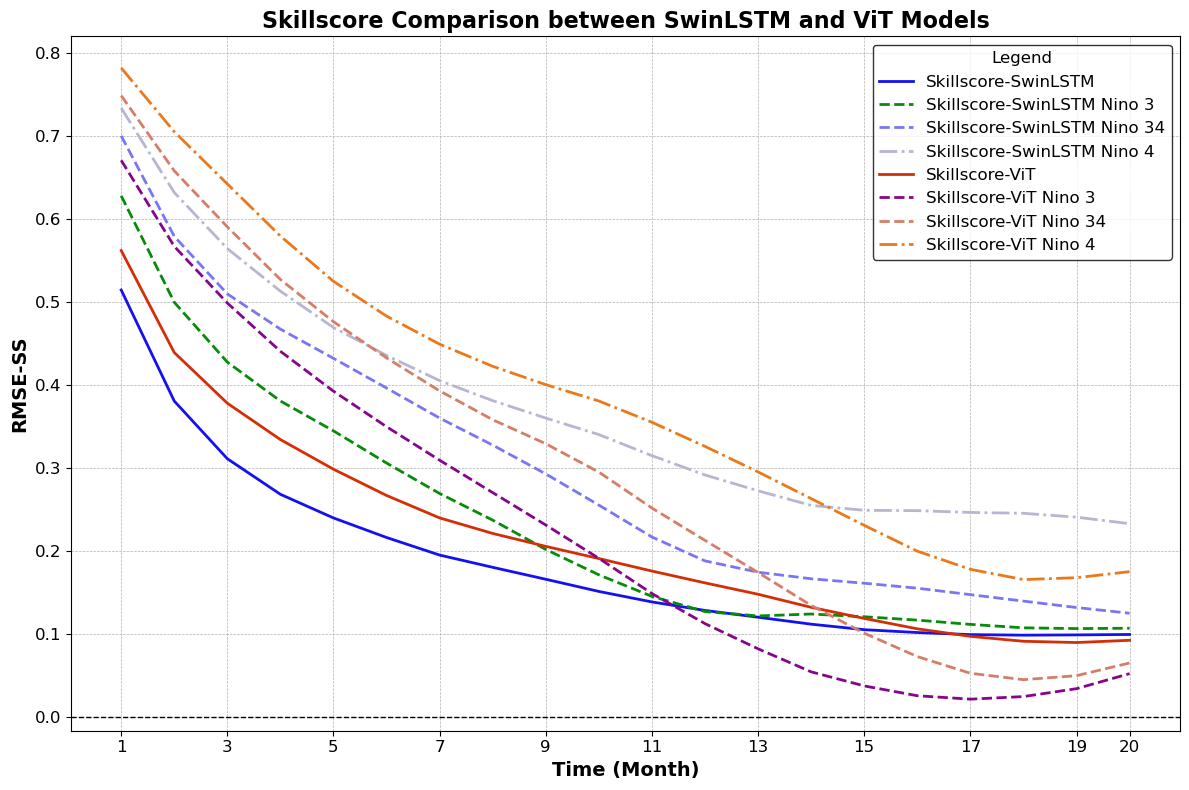

In [349]:
# ===========================================================================================================================
# Skillscore Comparison
# ===========================================================================================================================

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(12, 8))

if model == "both":
    # Plot skillscore for SwinLSTM
    ax.plot(data_swinlstm["skillscore"]["total"]["skillscore_mean"], label='Skillscore-SwinLSTM', color='#1410F2', linestyle='-', linewidth=2)
    ax.plot(data_swinlstm["skillscore"]["total"]["skillscore_mean_3i"], label='Skillscore-SwinLSTM Nino 3', color='#068c08', linestyle='--', linewidth=2)
    ax.plot(data_swinlstm["skillscore"]["total"]["skillscore_mean_34i"], label='Skillscore-SwinLSTM Nino 34', color='#7976F4', linestyle='--', linewidth=2)
    ax.plot(data_swinlstm["skillscore"]["total"]["skillscore_mean_4i"], label='Skillscore-SwinLSTM Nino 4', color='#B6B6D1', linestyle='-.', linewidth=2)

    # Plot skillscore for ViT
    ax.plot(data_vit["skillscore"]["total"]["skillscore_mean"], label='Skillscore-ViT', color='#D42E07', linestyle='-', linewidth=2)
    ax.plot(data_vit["skillscore"]["total"]["skillscore_mean_3i"], label='Skillscore-ViT Nino 3', color='#85068c', linestyle='--', linewidth=2)
    ax.plot(data_vit["skillscore"]["total"]["skillscore_mean_34i"], label='Skillscore-ViT Nino 34', color='#D67D68', linestyle='--', linewidth=2)
    ax.plot(data_vit["skillscore"]["total"]["skillscore_mean_4i"], label='Skillscore-ViT Nino 4', color='#EA791B', linestyle='-.', linewidth=2)

elif model == "vit":
    # Plot skillscore for ViT
    ax.plot(data_vit["skillscore"]["total"]["skillscore_mean"], label='Skillscore-ViT', color='#D42E07', linestyle='-', linewidth=2)
    ax.plot(data_vit["skillscore"]["total"]["skillscore_mean_3i"], label='Skillscore-ViT Nino 3', color='#85068c', linestyle='--', linewidth=2)
    ax.plot(data_vit["skillscore"]["total"]["skillscore_mean_34i"], label='Skillscore-ViT Nino 34', color='#D67D68', linestyle='--', linewidth=2)
    ax.plot(data_vit["skillscore"]["total"]["skillscore_mean_4i"], label='Skillscore-ViT Nino 4', color='#EA791B', linestyle='-.', linewidth=2)

elif model == "swin":
    # Plot skillscore for SwinLSTM
    ax.plot(data_swinlstm["skillscore"]["total"]["skillscore_mean"], label='Skillscore-SwinLSTM', color='#1410F2', linestyle='-', linewidth=2)
    ax.plot(data_swinlstm["skillscore"]["total"]["skillscore_mean_3i"], label='Skillscore-SwinLSTM Nino 3', color='#068c08', linestyle='--', linewidth=2)
    ax.plot(data_swinlstm["skillscore"]["total"]["skillscore_mean_34i"], label='Skillscore-SwinLSTM Nino 34', color='#7976F4', linestyle='--', linewidth=2)
    ax.plot(data_swinlstm["skillscore"]["total"]["skillscore_mean_4i"], label='Skillscore-SwinLSTM Nino 4', color='#B6B6D1', linestyle='-.', linewidth=2)

# Add a dashed line at y = 0
ax.axhline(y=0, color='black', linestyle='--', linewidth=1)

# Add grid for better readability
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Customize the legend
legend = ax.legend(loc='best', fontsize='large', title='Legend', title_fontsize='large')
legend.get_frame().set_edgecolor('black')

# Add labels and title
ax.set_xlabel('Time (Month)', fontsize=14, fontweight='bold')
ax.set_ylabel('RMSE-SS', fontsize=14, fontweight='bold')
ax.set_title('Skillscore Comparison between SwinLSTM and ViT Models', fontsize=16, fontweight='bold')

# Customize the x-axis labels to start at 1 and end at 20
num_points = len(data_vit["skillscore"]["total"]["skillscore_mean"])
x_ticks = list(range(0, num_points, max(1, num_points // 10)))

# Ensure the last month (20) is included
if (num_points - 1) not in x_ticks:
    x_ticks.append(num_points - 1)

ax.set_xticks(x_ticks)
ax.set_xticklabels(list(range(1, 20, 2)) + [20])

# Customize ticks
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=10)

# Show plot
plt.tight_layout()
plt.show()
fig.savefig(f'{save_dir}/skillscore_comparison.png')

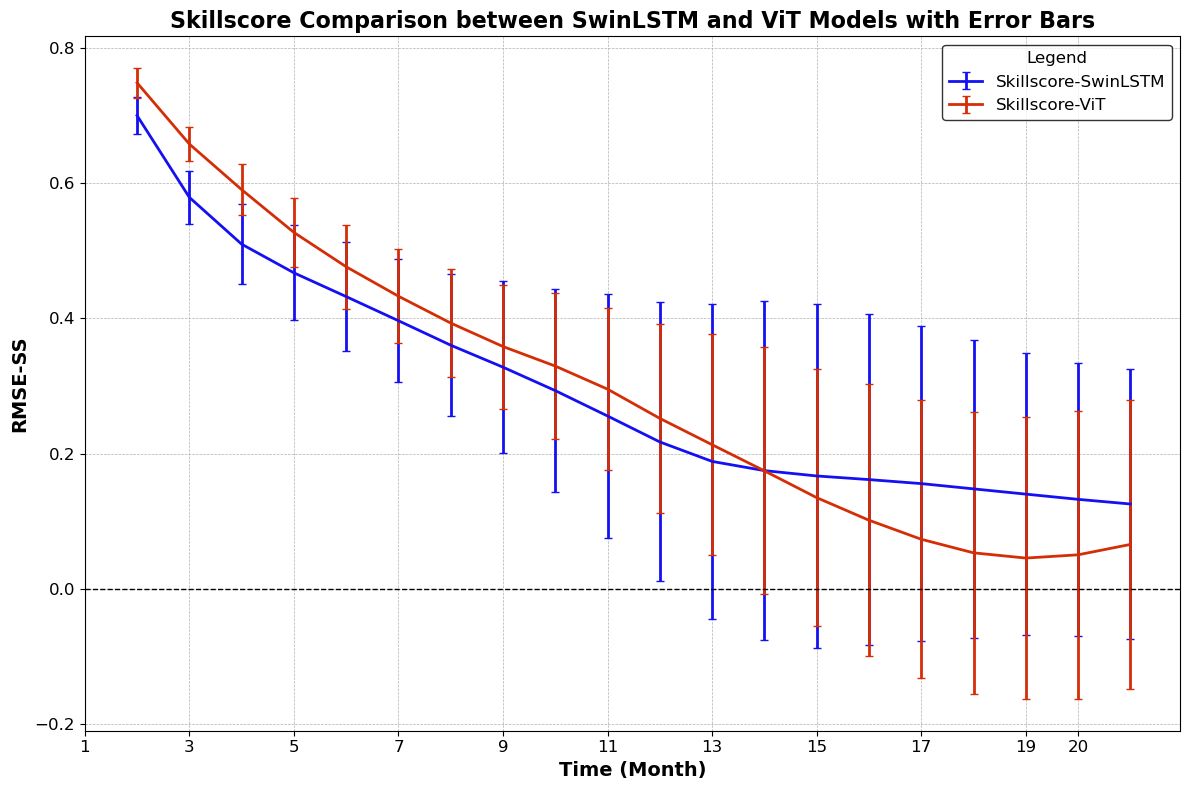

In [350]:
# Prepare the figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Define the metrics to be plotted
metrics = ['skillscore_mean']#, 'skillscore_mean_3i', 'skillscore_mean_34i', 'skillscore_mean_4i']
metrics = ['skillscore_mean_34i']

if model == "both":
    # SwinLSTM Metrics with error bars
    for metric, label, color, style in zip(
            metrics,
            ['Skillscore-SwinLSTM', 'Skillscore-SwinLSTM Nino 3', 'Skillscore-SwinLSTM Nino 34', 'Skillscore-SwinLSTM Nino 4'],
            ['#1410F2', '#068c08', '#7976F4', '#B6B6D1'],
            ['-', '--', '--', '-.']):
        
        mean_swinlstm, std_swinlstm = calculate_mean_std(data_swinlstm['skillscore'], metric)
        ax.errorbar(range(1, len(mean_swinlstm) + 1), mean_swinlstm, yerr=std_swinlstm, label=label, 
                    color=color, linestyle=style, linewidth=2, capsize=3)

    # ViT Metrics with error bars
    for metric, label, color, style in zip(
            metrics,
            ['Skillscore-ViT', 'Skillscore-ViT Nino 3', 'Skillscore-ViT Nino 34', 'Skillscore-ViT Nino 4'],
            ['#D42E07', '#85068c', '#D67D68', '#EA791B'],
            ['-', '--', '--', '-.']):
        
        mean_vit, std_vit = calculate_mean_std(data_vit['skillscore'], metric)
        ax.errorbar(range(1, len(mean_vit) + 1), mean_vit, yerr=std_vit, label=label, 
                    color=color, linestyle=style, linewidth=2, capsize=3)
elif model == "vit":
    # ViT Metrics with error bars
    for metric, label, color, style in zip(
            metrics,
            ['Skillscore-ViT', 'Skillscore-ViT Nino 3', 'Skillscore-ViT Nino 34', 'Skillscore-ViT Nino 4'],
            ['#D42E07', '#85068c', '#D67D68', '#EA791B'],
            ['-', '--', '--', '-.']):
        
        mean_vit, std_vit = calculate_mean_std(data_vit['skillscore'], metric)
        ax.errorbar(range(1, len(mean_vit) + 1), mean_vit, yerr=std_vit, label=label, 
                    color=color, linestyle=style, linewidth=2, capsize=3)
elif model == "swin":
    # SwinLSTM Metrics with error bars
    for metric, label, color, style in zip(
            metrics,
            ['Skillscore-SwinLSTM', 'Skillscore-SwinLSTM Nino 3', 'Skillscore-SwinLSTM Nino 34', 'Skillscore-SwinLSTM Nino 4'],
            ['#1410F2', '#068c08', '#7976F4', '#B6B6D1'],
            ['-', '--', '--', '-.']):
        
        mean_swinlstm, std_swinlstm = calculate_mean_std(data_swinlstm['skillscore'], metric)
        ax.errorbar(range(1, len(mean_swinlstm) + 1), mean_swinlstm, yerr=std_swinlstm, label=label, 
                    color=color, linestyle=style, linewidth=2, capsize=3)

# Add a dashed line at y = 0 to represent no skill
ax.axhline(y=0, color='black', linestyle='--', linewidth=1)

# Add grid for better readability
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Customize the legend
legend = ax.legend(loc='best', fontsize='large', title='Legend', title_fontsize='large')
legend.get_frame().set_edgecolor('black')

# Add labels and title
ax.set_xlabel('Time (Month)', fontsize=14, fontweight='bold')
ax.set_ylabel('RMSE-SS', fontsize=14, fontweight='bold')
ax.set_title('Skillscore Comparison between SwinLSTM and ViT Models with Error Bars', fontsize=16, fontweight='bold')

# Customize the x-axis labels to start at 1 and end at the correct number of time points
num_points = len(mean_vit)  # Use the length of the skillscore values as the number of time points
x_ticks = list(range(0, num_points, max(1, num_points // 10)))

# Ensure the last point is included
if (num_points - 1) not in x_ticks:
    x_ticks.append(num_points - 1)

ax.set_xticks(x_ticks)
ax.set_xticklabels(list(range(1, 20, 2)) + [20])

# Customize ticks
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=10)

# Show plot
plt.tight_layout()
plt.show()

# Save the figure
fig.savefig(f'{save_dir}/{metrics[0]}_comparison_with_errorbars.png')

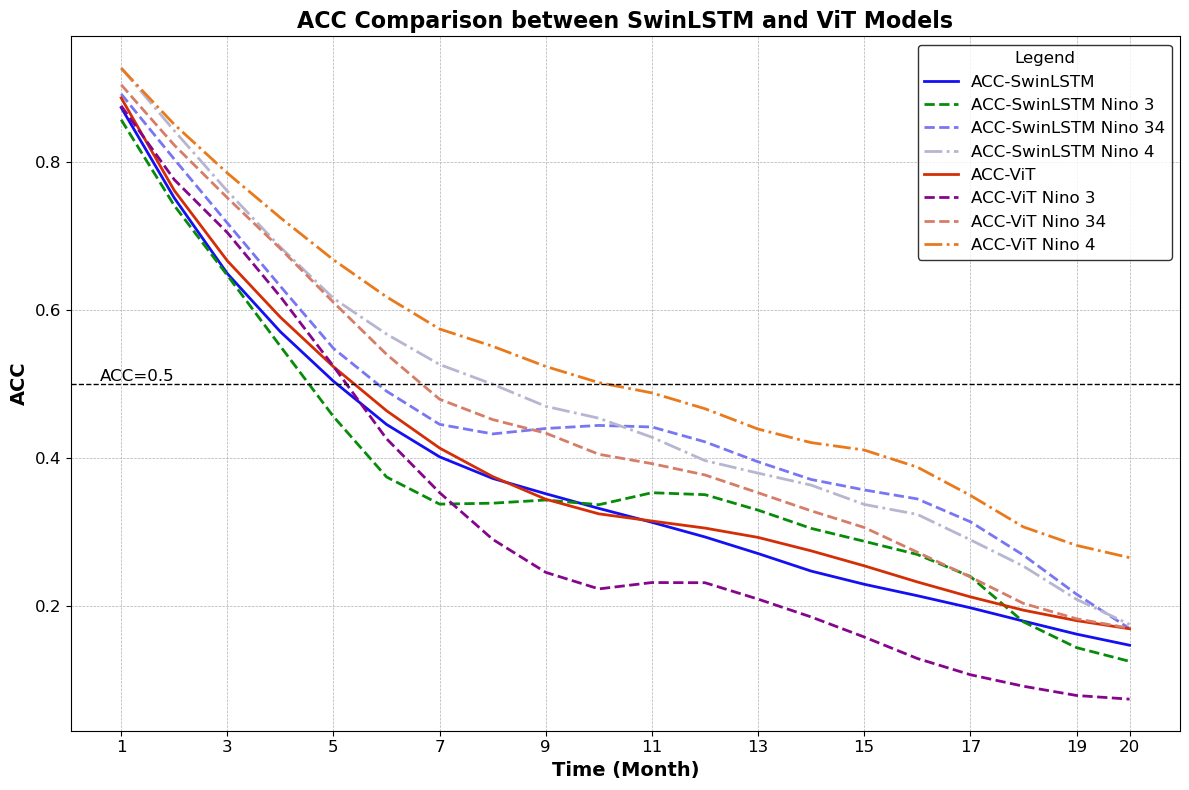

In [351]:
# ===========================================================================================================================
# ACC Comparison
# ===========================================================================================================================


# Create a figure and axis object
fig, ax = plt.subplots(figsize=(12, 8))

if model == "both":
    # Plot ACC for SwinLSTM
    ax.plot(data_swinlstm["acc"]["total"]["acc_mean"], label='ACC-SwinLSTM', color='#1410F2', linestyle='-', linewidth=2)
    ax.plot(data_swinlstm["acc"]["total"]["acc_mean_3i"], label='ACC-SwinLSTM Nino 3', color='#068c08', linestyle='--', linewidth=2)
    ax.plot(data_swinlstm["acc"]["total"]["acc_mean_34i"], label='ACC-SwinLSTM Nino 34', color='#7976F4', linestyle='--', linewidth=2)
    ax.plot(data_swinlstm["acc"]["total"]["acc_mean_4i"], label='ACC-SwinLSTM Nino 4', color='#B6B6D1', linestyle='-.', linewidth=2)

    # Plot ACC for ViT
    ax.plot(data_vit["acc"]["total"]["acc_mean"], label='ACC-ViT', color='#D42E07', linestyle='-', linewidth=2)
    ax.plot(data_vit["acc"]["total"]["acc_mean_3i"], label='ACC-ViT Nino 3', color='#85068c', linestyle='--', linewidth=2)
    ax.plot(data_vit["acc"]["total"]["acc_mean_34i"], label='ACC-ViT Nino 34', color='#D67D68', linestyle='--', linewidth=2)
    ax.plot(data_vit["acc"]["total"]["acc_mean_4i"], label='ACC-ViT Nino 4', color='#EA791B', linestyle='-.', linewidth=2)

elif model == "vit":
    # Plot ACC for ViT
    ax.plot(data_vit["acc"]["total"]["acc_mean"], label='ACC-ViT', color='#D42E07', linestyle='-', linewidth=2)
    ax.plot(data_vit["acc"]["total"]["acc_mean_3i"], label='ACC-ViT Nino 3', color='#85068c', linestyle='--', linewidth=2)
    ax.plot(data_vit["acc"]["total"]["acc_mean_34i"], label='ACC-ViT Nino 34', color='#D67D68', linestyle='--', linewidth=2)
    ax.plot(data_vit["acc"]["total"]["acc_mean_4i"], label='ACC-ViT Nino 4', color='#EA791B', linestyle='-.', linewidth=2)

elif model == "swin":
    # Plot ACC for SwinLSTM
    ax.plot(data_swinlstm["acc"]["total"]["acc_mean"], label='ACC-SwinLSTM', color='#1410F2', linestyle='-', linewidth=2)
    ax.plot(data_swinlstm["acc"]["total"]["acc_mean_3i"], label='ACC-SwinLSTM Nino 3', color='#068c08', linestyle='--', linewidth=2)
    ax.plot(data_swinlstm["acc"]["total"]["acc_mean_34i"], label='ACC-SwinLSTM Nino 34', color='#7976F4', linestyle='--', linewidth=2)
    ax.plot(data_swinlstm["acc"]["total"]["acc_mean_4i"], label='ACC-SwinLSTM Nino 4', color='#B6B6D1', linestyle='-.', linewidth=2)

# Add a dashed line at y = 0.5 with a label
ax.axhline(y=0.5, color='black', linestyle='--', linewidth=1)
ax.text(x=1, y=0.5, s='ACC=0.5', color='black', fontsize=12, verticalalignment='bottom', horizontalalignment='right')

# Add grid for better readability
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Customize the legend
legend = ax.legend(loc='best', fontsize='large', title='Legend', title_fontsize='large')
legend.get_frame().set_edgecolor('black')

# Add labels and title
ax.set_xlabel('Time (Month)', fontsize=14, fontweight='bold')
ax.set_ylabel('ACC', fontsize=14, fontweight='bold')
ax.set_title('ACC Comparison between SwinLSTM and ViT Models', fontsize=16, fontweight='bold')

# Customize the x-axis labels to start at 1 and end at 20
num_points = len(data_vit["acc"]["total"]["acc_mean"])
x_ticks = list(range(0, num_points, max(1, num_points // 10)))

# Ensure the last month (20) is included
if (num_points - 1) not in x_ticks:
    x_ticks.append(num_points - 1)

ax.set_xticks(x_ticks)
ax.set_xticklabels(list(range(1, 20, 2)) + [20])

# Customize ticks
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=10)

# Show plot
plt.tight_layout()
plt.show()
fig.savefig(f'{save_dir}/acc_comparison.png')

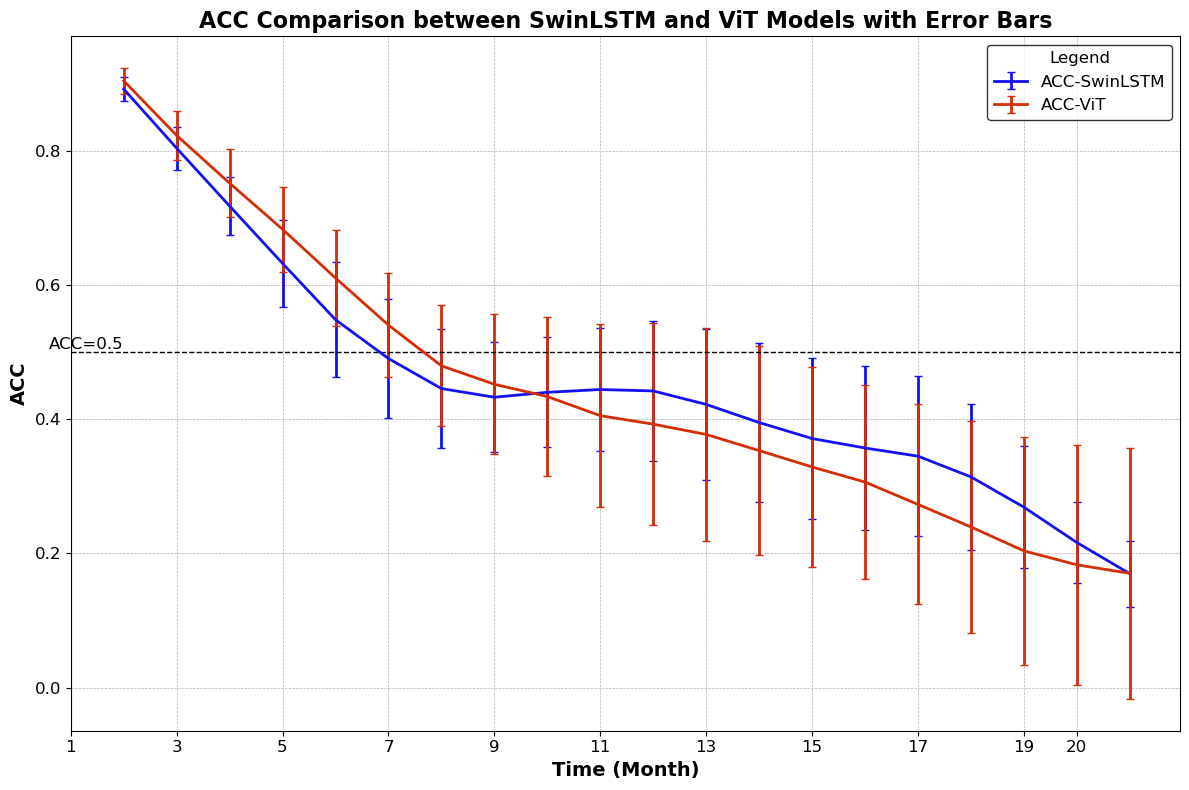

In [352]:
# Prepare the figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Define the metrics to be plotted
metrics = ['acc_mean']#, 'acc_mean_3i', 'acc_mean_34i', 'acc_mean_4i']
metrics = ['acc_mean_34i']

if model == "both":
    # SwinLSTM Metrics with error bars
    for metric, label, color, style in zip(
            metrics,
            ['ACC-SwinLSTM', 'ACC-SwinLSTM Nino 3', 'ACC-SwinLSTM Nino 34', 'ACC-SwinLSTM Nino 4'],
            ['#1410F2', '#068c08', '#7976F4', '#B6B6D1'],
            ['-', '--', '--', '-.']):
        
        mean_swinlstm, std_swinlstm = calculate_mean_std(data_swinlstm['acc'], metric)
        ax.errorbar(range(1, len(mean_swinlstm) + 1), mean_swinlstm, yerr=std_swinlstm, label=label, 
                    color=color, linestyle=style, linewidth=2, capsize=3)

    # ViT Metrics with error bars
    for metric, label, color, style in zip(
            metrics,
            ['ACC-ViT', 'ACC-ViT Nino 3', 'ACC-ViT Nino 34', 'ACC-ViT Nino 4'],
            ['#D42E07', '#85068c', '#D67D68', '#EA791B'],
            ['-', '--', '--', '-.']):
        
        mean_vit, std_vit = calculate_mean_std(data_vit['acc'], metric)
        ax.errorbar(range(1, len(mean_vit) + 1), mean_vit, yerr=std_vit, label=label, 
                    color=color, linestyle=style, linewidth=2, capsize=3)
elif model == "vit":
    # ViT Metrics with error bars
    for metric, label, color, style in zip(
            metrics,
            ['ACC-ViT', 'ACC-ViT Nino 3', 'ACC-ViT Nino 34', 'ACC-ViT Nino 4'],
            ['#D42E07', '#85068c', '#D67D68', '#EA791B'],
            ['-', '--', '--', '-.']):
        
        mean_vit, std_vit = calculate_mean_std(data_vit['acc'], metric)
        ax.errorbar(range(1, len(mean_vit) + 1), mean_vit, yerr=std_vit, label=label, 
                    color=color, linestyle=style, linewidth=2, capsize=3)
elif model == "swin":
    # SwinLSTM Metrics with error bars
    for metric, label, color, style in zip(
            metrics,
            ['ACC-SwinLSTM', 'ACC-SwinLSTM Nino 3', 'ACC-SwinLSTM Nino 34', 'ACC-SwinLSTM Nino 4'],
            ['#1410F2', '#068c08', '#7976F4', '#B6B6D1'],
            ['-', '--', '--', '-.']):
        
        mean_swinlstm, std_swinlstm = calculate_mean_std(data_swinlstm['acc'], metric)
        ax.errorbar(range(1, len(mean_swinlstm) + 1), mean_swinlstm, yerr=std_swinlstm, label=label, 
                    color=color, linestyle=style, linewidth=2, capsize=3)

# Add a dashed line at y = 0.5 with a label
ax.axhline(y=0.5, color='black', linestyle='--', linewidth=1)
ax.text(x=1, y=0.5, s='ACC=0.5', color='black', fontsize=12, verticalalignment='bottom', horizontalalignment='right')

# Add grid for better readability
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Customize the legend
legend = ax.legend(loc='best', fontsize='large', title='Legend', title_fontsize='large')
legend.get_frame().set_edgecolor('black')

# Add labels and title
ax.set_xlabel('Time (Month)', fontsize=14, fontweight='bold')
ax.set_ylabel('ACC', fontsize=14, fontweight='bold')
ax.set_title('ACC Comparison between SwinLSTM and ViT Models with Error Bars', fontsize=16, fontweight='bold')

# Customize the x-axis labels to start at 1 and end at the correct number of time points
num_points = len(mean_vit)  # Use the length of the ACC values as the number of time points
x_ticks = list(range(0, num_points, max(1, num_points // 10)))

# Ensure the last point is included
if (num_points - 1) not in x_ticks:
    x_ticks.append(num_points - 1)

ax.set_xticks(x_ticks)
ax.set_xticklabels(list(range(1, 20, 2)) + [20])

# Customize ticks
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=10)

# Show plot
plt.tight_layout()
plt.show()

# Save the figure
fig.savefig(f'{save_dir}/{metrics[0]}_comparison_with_errorbars.png')

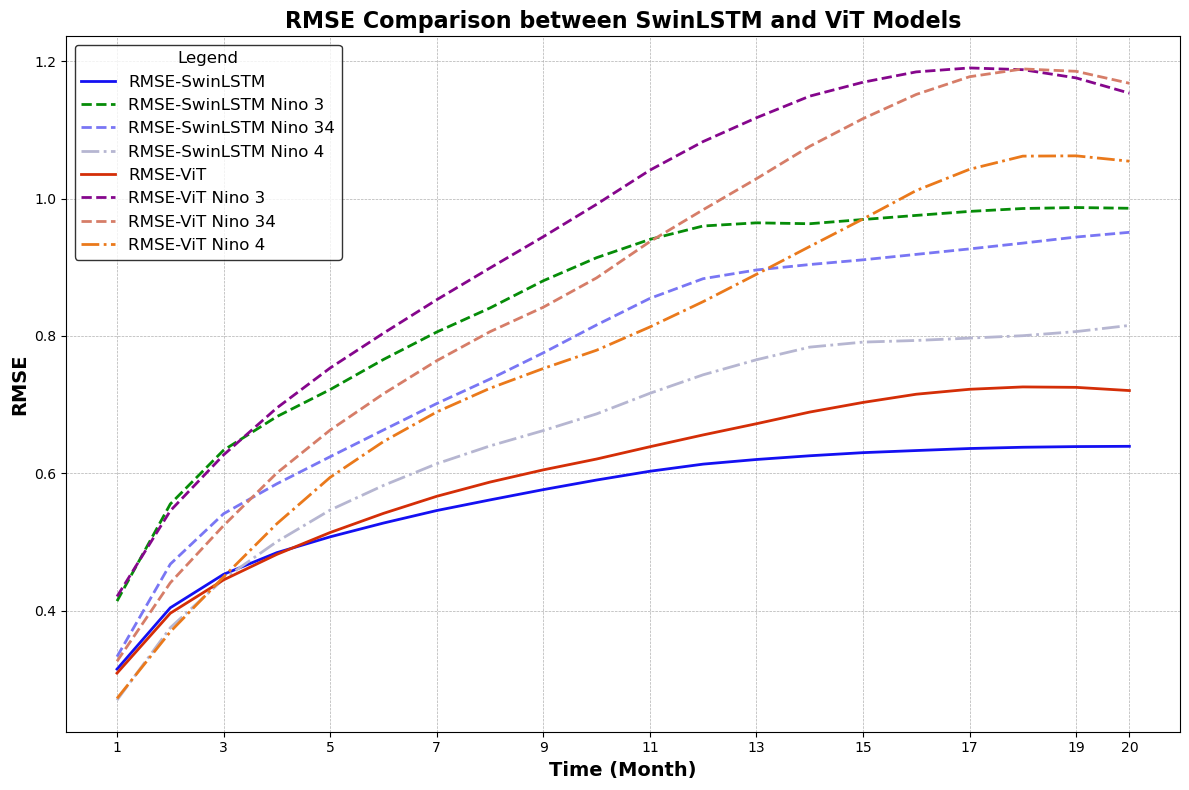

In [353]:
# ===========================================================================================================================
# RMSE Comparison
# ===========================================================================================================================

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(12, 8))

if model == "both":
    # Plot RMSE for SwinLSTM
    ax.plot(data_swinlstm["loss"]["total"]["rmse"], label='RMSE-SwinLSTM', color='#1410F2', linestyle='-', linewidth=2)
    ax.plot(data_swinlstm["loss"]["total"]["nino_rmse_3_l"], label='RMSE-SwinLSTM Nino 3', color='#068c08', linestyle='--', linewidth=2)
    ax.plot(data_swinlstm["loss"]["total"]["nino_rmse_34_l"], label='RMSE-SwinLSTM Nino 34', color='#7976F4', linestyle='--', linewidth=2)
    ax.plot(data_swinlstm["loss"]["total"]["nino_rmse_4_l"], label='RMSE-SwinLSTM Nino 4', color='#B6B6D1', linestyle='-.', linewidth=2)

    # Plot RMSE for ViT
    ax.plot(data_vit["loss"]["total"]["rmse"], label='RMSE-ViT', color='#D42E07', linestyle='-', linewidth=2)
    ax.plot(data_vit["loss"]["total"]["nino_rmse_3_l"], label='RMSE-ViT Nino 3', color='#85068c', linestyle='--', linewidth=2)
    ax.plot(data_vit["loss"]["total"]["nino_rmse_34_l"], label='RMSE-ViT Nino 34', color='#D67D68', linestyle='--', linewidth=2)
    ax.plot(data_vit["loss"]["total"]["nino_rmse_4_l"], label='RMSE-ViT Nino 4', color='#EA791B', linestyle='-.', linewidth=2)

elif model == "vit":
    # Plot RMSE for ViT
    ax.plot(data_vit["loss"]["total"]["rmse"], label='RMSE-ViT', color='#D42E07', linestyle='-', linewidth=2)
    ax.plot(data_vit["loss"]["total"]["nino_rmse_3_l"], label='RMSE-ViT Nino 3', color='#85068c', linestyle='--', linewidth=2)
    ax.plot(data_vit["loss"]["total"]["nino_rmse_34_l"], label='RMSE-ViT Nino 34', color='#D67D68', linestyle='--', linewidth=2)
    ax.plot(data_vit["loss"]["total"]["nino_rmse_4_l"], label='RMSE-ViT Nino 4', color='#EA791B', linestyle='-.', linewidth=2)

elif model == "swin":
    # Plot RMSE for SwinLSTM
    ax.plot(data_swinlstm["loss"]["total"]["rmse"], label='RMSE-SwinLSTM', color='#1410F2', linestyle='-', linewidth=2)
    ax.plot(data_swinlstm["loss"]["total"]["nino_rmse_3_l"], label='RMSE-SwinLSTM Nino 3', color='#068c08', linestyle='--', linewidth=2)
    ax.plot(data_swinlstm["loss"]["total"]["nino_rmse_34_l"], label='RMSE-SwinLSTM Nino 34', color='#7976F4', linestyle='--', linewidth=2)
    ax.plot(data_swinlstm["loss"]["total"]["nino_rmse_4_l"], label='RMSE-SwinLSTM Nino 4', color='#B6B6D1', linestyle='-.', linewidth=2)

# Add grid for better readability
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Customize the legend
legend = ax.legend(loc='best', fontsize='large', title='Legend', title_fontsize='large')
legend.get_frame().set_edgecolor('black')

# Add labels and title
ax.set_xlabel('Time (Month)', fontsize=14, fontweight='bold')
ax.set_ylabel('RMSE', fontsize=14, fontweight='bold')
ax.set_title('RMSE Comparison between SwinLSTM and ViT Models', fontsize=16, fontweight='bold')

# Customize the x-axis labels to start at 1 and end at 20
num_points = len(data_vit["loss"]["total"]["rmse"])
x_ticks = list(range(0, num_points, max(1, num_points // 10)))

# Ensure the last month (20) is included
if (num_points - 1) not in x_ticks:
    x_ticks.append(num_points - 1)

ax.set_xticks(x_ticks)
ax.set_xticklabels(list(range(1, 20, 2)) + [20])

# Show plot
plt.tight_layout()
plt.show()
fig.savefig(f'{save_dir}/rmse_comparison.png')

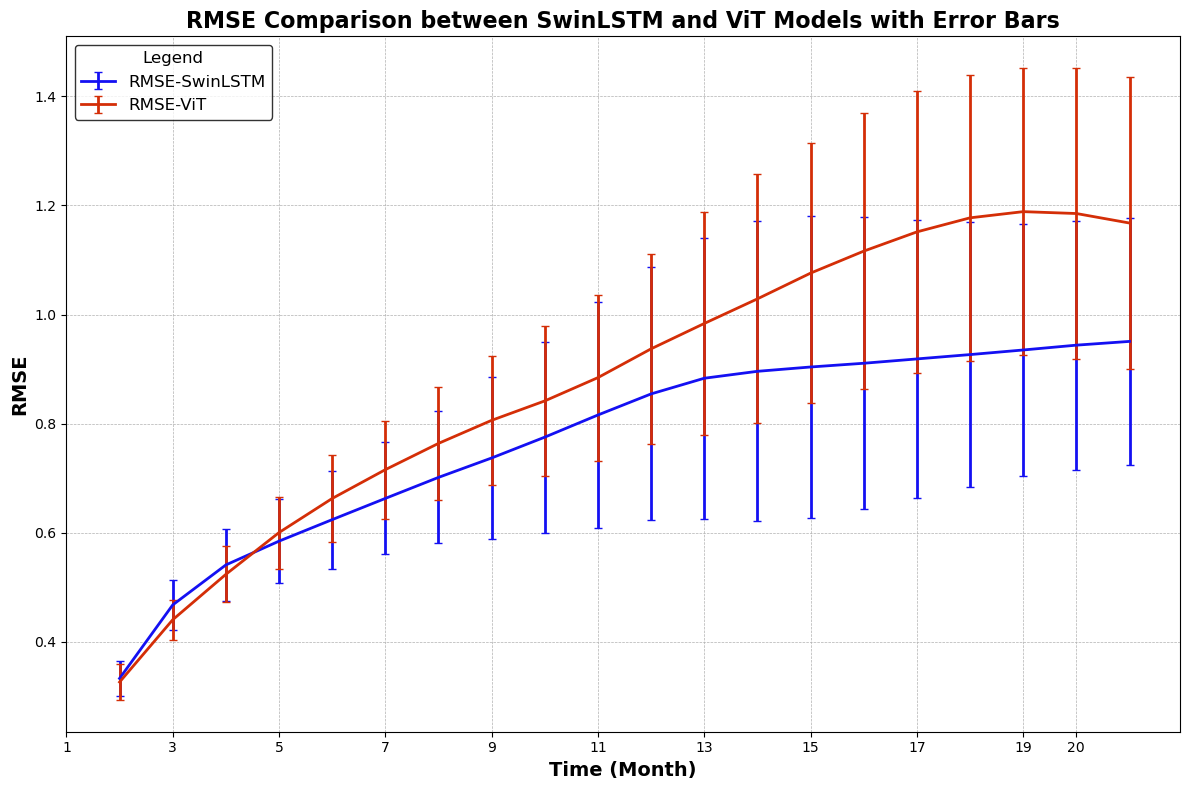

In [354]:
# Assuming the loss_dict has the shape: {'subsample_0': {'rmse': ..., 'nino_rmse_3_l': ..., ...}, ...}

# Prepare the figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Calculate the means and std for each metric for SwinLSTM and ViT models
metrics = ['rmse']#, 'nino_rmse_3_l', 'nino_rmse_34_l', 'nino_rmse_4_l']
metrics = ['nino_rmse_34_l']

if model == "both":
    # SwinLSTM Metrics
    for metric, label, color, style in zip(
            metrics,
            ['RMSE-SwinLSTM', 'RMSE-SwinLSTM Nino 3', 'RMSE-SwinLSTM Nino 34', 'RMSE-SwinLSTM Nino 4'],
            ['#1410F2', '#068c08', '#7976F4', '#B6B6D1'],
            ['-', '--', '--', '-.']):
        
        mean_swinlstm, std_swinlstm = calculate_mean_std(data_swinlstm['loss'], metric)
        ax.errorbar(range(1, len(mean_swinlstm) + 1), mean_swinlstm, yerr=std_swinlstm, label=label, 
                    color=color, linestyle=style, linewidth=2, capsize=3)

    # ViT Metrics
    for metric, label, color, style in zip(
            metrics,
            ['RMSE-ViT', 'RMSE-ViT Nino 3', 'RMSE-ViT Nino 34', 'RMSE-ViT Nino 4'],
            ['#D42E07', '#85068c', '#D67D68', '#EA791B'],
            ['-', '--', '--', '-.']):
        
        mean_vit, std_vit = calculate_mean_std(data_vit['loss'], metric)
        ax.errorbar(range(1, len(mean_vit) + 1), mean_vit, yerr=std_vit, label=label, 
                    color=color, linestyle=style, linewidth=2, capsize=3)
elif model == "vit":
    # ViT Metrics
    for metric, label, color, style in zip(
            metrics,
            ['RMSE-ViT', 'RMSE-ViT Nino 3', 'RMSE-ViT Nino 34', 'RMSE-ViT Nino 4'],
            ['#D42E07', '#85068c', '#D67D68', '#EA791B'],
            ['-', '--', '--', '-.']):
        
        mean_vit, std_vit = calculate_mean_std(data_vit['loss'], metric)
        ax.errorbar(range(1, len(mean_vit) + 1), mean_vit, yerr=std_vit, label=label, 
                    color=color, linestyle=style, linewidth=2, capsize=3)
elif model == "swin":
    # SwinLSTM Metrics
    for metric, label, color, style in zip(
            metrics,
            ['RMSE-SwinLSTM', 'RMSE-SwinLSTM Nino 3', 'RMSE-SwinLSTM Nino 34', 'RMSE-SwinLSTM Nino 4'],
            ['#1410F2', '#068c08', '#7976F4', '#B6B6D1'],
            ['-', '--', '--', '-.']):
        
        mean_swinlstm, std_swinlstm = calculate_mean_std(data_swinlstm['loss'], metric)
        ax.errorbar(range(1, len(mean_swinlstm) + 1), mean_swinlstm, yerr=std_swinlstm, label=label, 
                    color=color, linestyle=style, linewidth=2, capsize=3)

# Add grid for better readability
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Customize the legend
legend = ax.legend(loc='best', fontsize='large', title='Legend', title_fontsize='large')
legend.get_frame().set_edgecolor('black')

# Add labels and title
ax.set_xlabel('Time (Month)', fontsize=14, fontweight='bold')
ax.set_ylabel('RMSE', fontsize=14, fontweight='bold')
ax.set_title('RMSE Comparison between SwinLSTM and ViT Models with Error Bars', fontsize=16, fontweight='bold')

# Customize the x-axis labels to start at 1 and end at the correct number of time points
num_points = len(mean_vit)  # Use the length of RMSE values as the number of time points
x_ticks = list(range(0, num_points, max(1, num_points // 10)))

# Ensure the last point is included
if (num_points - 1) not in x_ticks:
    x_ticks.append(num_points - 1)

ax.set_xticks(x_ticks)
ax.set_xticklabels(list(range(1, 20, 2)) + [20])

# Show plot
plt.tight_layout()
plt.show()

# Save the figure
fig.savefig(f'{save_dir}/{metrics[0]}_comparison_with_errorbars.png')

In [355]:
# ===========================================================================================================================
# Loading Data
# ===========================================================================================================================

# Set the device to GPU if available
device= torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
PATH = "C:/Users/felix/PycharmProjects/deeps2a-enso/scripts/"


# Load the configuration files
cfg_vit = data_vit["config"]
#cfg_swinlstm = data_swinlstm["config"]


# Selecting the data directories
if cfg_vit["temp_ocean"]:
    cfg_vit["data_dir"] = PATH + '/../../data/processed_data/cesm2_lens/piControl/test/'
else:
    cfg_vit["data_dir"] = PATH + '/../../data/processed_data/cesm2_lens/piControl/sst_ssh/'

cfg_vit["lsm_path"] = PATH + '/../data/processed_data/enso_data_pacific/land_sea_mask_common.nc'
cfg_vit["oras5_dir"] = PATH + '/../data/processed_data/enso_data_pacific/oras5/'


# Load common land sea mask
common_lsm = xr.open_dataset(cfg_vit['lsm_path'])['lsm'].data
lsm = torch.as_tensor(common_lsm, device = device, dtype = torch.long)


# Load the validation xarray dataset
if cfg_vit["1_2_grid"]:
    val_ds_adapt = xr.open_dataset(PATH + "/evaluation/results/val_ds_adapt_1_2_grid.nc")
else:
    val_ds_adapt = xr.open_dataset(PATH + "/evaluation/results/val_ds_adapt.nc")

lsm = common_lsm[cfg_vit["lat_range"][0]:cfg_vit["lat_range"][1], cfg_vit["lon_range"][0]:cfg_vit["lon_range"][1]]


# Adjust the grid region if 1_2_grid is set to True
if cfg_vit["adjust_grid_region"]:
    val_ds_adapt = val_ds_adapt.sel(lat=slice(-26, 25), lon=slice(148, 279))
    lsm = lsm[:51, 29:95]


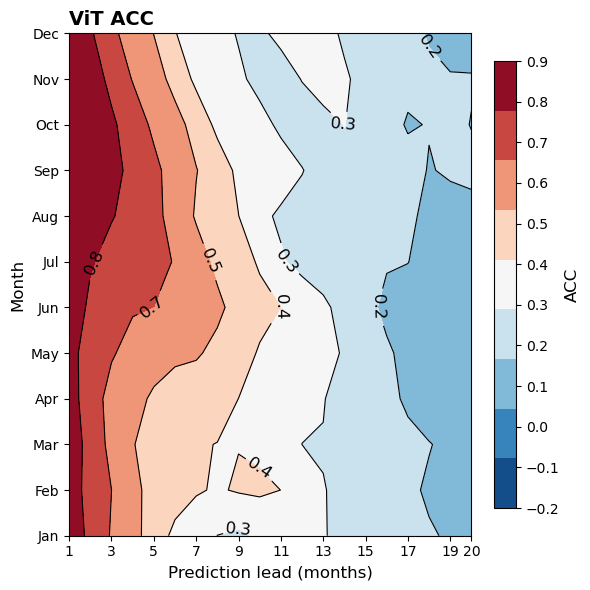

In [356]:
# ===========================================================================================================================
# Monthly ACC Plot
# ===========================================================================================================================

#["acc_mean"]
#["acc_mean_3i"]
#["acc_mean_34i"]
#["acc_mean_4i"]
#["acc_mean_spatial"]
#["acc_mean_3i_spatial"]
#["acc_mean_34i_spatial"]
#["acc_mean_4i_spatial"]

monthly_acc = data_vit["monthly_acc"]
title = "ViT ACC"

# Prepare data for contour plotting
# Create a 2D array where each row represents a month and each column represents the forecast horizon (lag)
acc_values = np.array([monthly_acc[i]['acc_mean'] for i in range(1, 13)])

# Create the figure and axis
fig, ax = plt.subplots(figsize=(6, 6))

# Plot the contours using the ACC data
# Use a filled contour plot
cmap = 'RdBu_r'  # Red-Blue colormap, reversed
contour = ax.contourf(np.arange(0, 20), np.arange(1, 13), acc_values, levels=np.linspace(-0.2, 0.9, 10), cmap=cmap)

# Add contour lines
contour_lines = ax.contour(np.arange(0, 20), np.arange(1, 13), acc_values, levels=np.linspace(-0.2, 0.9, 10), colors='black', linewidths=0.8)
ax.clabel(contour_lines, fmt='%1.1f', inline=True, fontsize=12)

# Set x and y axis labels
ax.set_xlabel('Prediction lead (months)', fontsize=12)
ax.set_ylabel('Month', fontsize=12)

# Customize the x-axis labels to start at 1 and end at 20
num_points = len(data_vit["monthly_acc"][1]['acc_mean'])
x_ticks = list(range(0, num_points, max(1, num_points // 10)))

# Ensure the last month (20) is included
if (num_points - 1) not in x_ticks:
    x_ticks.append(num_points - 1)

ax.set_xticks(x_ticks)
ax.set_xticklabels(list(range(1, 21, 2)) + [20])

ax.set_yticks(np.arange(1, 13, step=1))  # All 12 months
ax.set_yticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=10)

# Add a title
ax.set_title(title, fontsize=14, loc='left', fontweight='bold')

# Add color bar to the right of the plot
cbar = fig.colorbar(contour, ax=ax, orientation='vertical', pad=0.05, fraction=0.05)
cbar.set_label('ACC', fontsize=12)
cbar.ax.tick_params(labelsize=10)

# Define the ticks for the color bar, increasing by 0.1
cbar.set_ticks(np.arange(cbar.vmin, cbar.vmax + 0.1, 0.1))

# Add grid lines for clarity
ax.grid(False)

# Adjust layout to match the style more closely
plt.tight_layout()

# Save the figure (for publication-quality output)
plt.savefig(f'{save_dir}/acc_montly_contour_plot.png')

# Show the plot
plt.show()

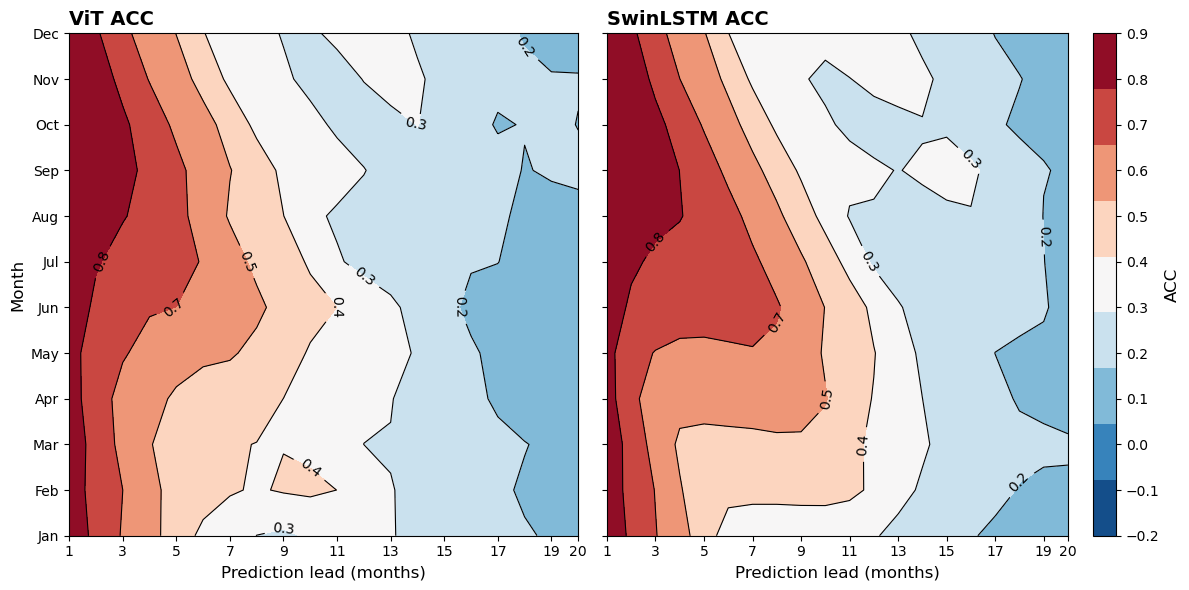

In [357]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Assuming data_vit and data_swinlstm contain the necessary monthly_acc values
monthly_acc_vit = data_vit["monthly_acc"]
monthly_acc_swinlstm = data_swinlstm["monthly_acc"]
title_1 = "ViT ACC"
title_2 = "SwinLSTM ACC"

# Prepare data for contour plotting for both models
acc_values_vit = np.array([monthly_acc_vit[i]['acc_mean'] for i in range(1, 13)])
acc_values_swinlstm = np.array([monthly_acc_swinlstm[i]['acc_mean'] for i in range(1, 13)])

# Create the figure and axis with 2 columns for both models
fig, axs = plt.subplots(ncols=2, figsize=(12, 6), sharey=True)

# Set a consistent colormap and contour levels
cmap = 'RdBu_r'  # Red-Blue colormap, reversed
levels = np.linspace(-0.2, 0.9, 10)  # Adjust levels for consistency

# Plot for ViT (Left plot)
contour_vit = axs[0].contourf(np.arange(0, 20), np.arange(1, 13), acc_values_vit, levels=levels, cmap=cmap)
contour_lines_vit = axs[0].contour(np.arange(0, 20), np.arange(1, 13), acc_values_vit, levels=levels, colors='black', linewidths=0.8)
axs[0].clabel(contour_lines_vit, fmt='%1.1f', inline=True, fontsize=10)
axs[0].set_title(title_1, fontsize=14, loc='left', fontweight='bold')
axs[0].set_xlabel('Prediction lead (months)', fontsize=12)
axs[0].set_ylabel('Month', fontsize=12)

# Plot for SwinLSTM (Right plot)
contour_swinlstm = axs[1].contourf(np.arange(0, 20), np.arange(1, 13), acc_values_swinlstm, levels=levels, cmap=cmap)
contour_lines_swinlstm = axs[1].contour(np.arange(0, 20), np.arange(1, 13), acc_values_swinlstm, levels=levels, colors='black', linewidths=0.8)
axs[1].clabel(contour_lines_swinlstm, fmt='%1.1f', inline=True, fontsize=10)
axs[1].set_title(title_2, fontsize=14, loc='left', fontweight='bold')
axs[1].set_xlabel('Prediction lead (months)', fontsize=12)


axs[0].set_xticks(x_ticks)
axs[0].set_xticklabels(list(range(1, 21, 2)) + [20])
axs[1].set_xticks(x_ticks)
axs[1].set_xticklabels(list(range(1, 21, 2)) + [20])

# Customize the y-axis labels to display all months
yticks = np.arange(1, 13)
yticklabels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
axs[0].set_yticks(yticks)
axs[0].set_yticklabels(yticklabels, fontsize=10)

# Create a divider for the rightmost plot and add the colorbar to the right of both plots
divider = make_axes_locatable(axs[1])
cax = divider.append_axes("right", size="5%", pad=0.25)  # Increase pad to 0.15 for more spacing

# Add color bar on the right side of the figure (next to the second plot)
cbar = fig.colorbar(contour_swinlstm, cax=cax)
cbar.set_label('ACC', fontsize=12)
cbar.ax.tick_params(labelsize=10)

# Define the ticks for the color bar, increasing by 0.1
cbar.set_ticks(np.arange(cbar.vmin, cbar.vmax + 0.1, 0.1))

# Adjust layout for better spacing
plt.tight_layout()

# Save the figure for publication-quality output
plt.savefig(f'{save_dir}/acc_comparison_vit_swinlstm.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

C:\Users\felix\AppData\Local\Temp\ipykernel_22392\824062886.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.1, 1, 0.93])


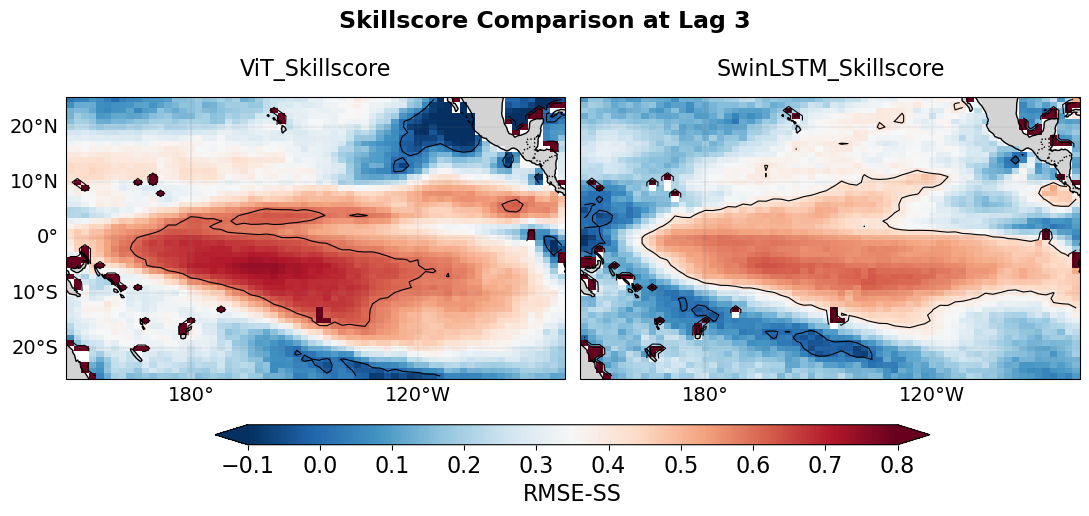

C:\Users\felix\AppData\Local\Temp\ipykernel_22392\824062886.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.1, 1, 0.93])


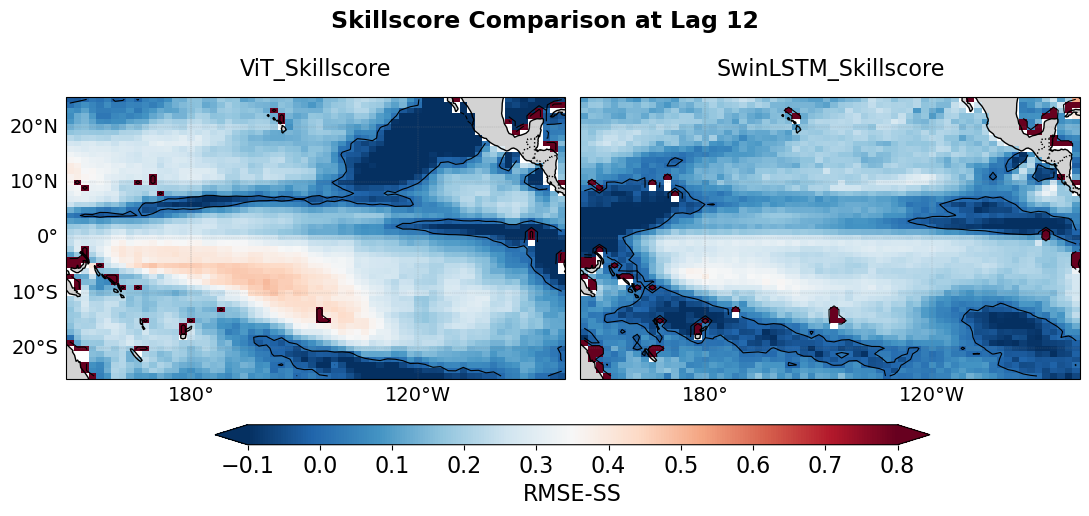

C:\Users\felix\AppData\Local\Temp\ipykernel_22392\824062886.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.1, 1, 0.93])


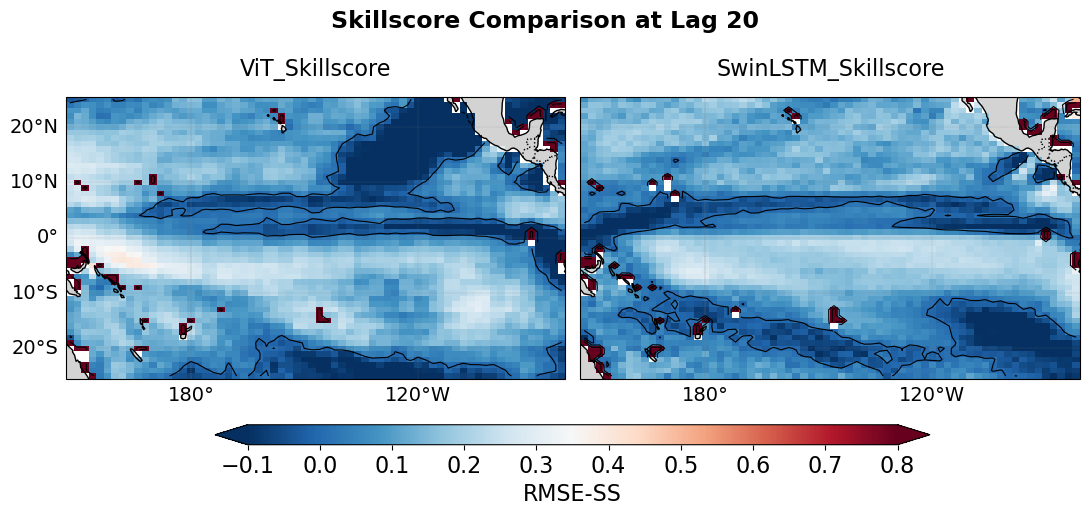

In [358]:
# ===========================================================================================================================
# Skillscore Spatial Forecast Plot
# ===========================================================================================================================
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Selecting Skillscore of 12 month forecast
vit_skillscore = data_vit["skillscore"]["total"]["skillscore_"]
swinlstm_skillscore = data_swinlstm["skillscore"]["total"]["skillscore_"]

lags = [3, 12, 20]

for lag in lags:
    vit_skillscore_ = vit_skillscore[lag-1]
    swinlstm_skillscore_ = swinlstm_skillscore[lag-1]

    hindcast = dict()
    for key, x in dict(ViT_Skillscore=vit_skillscore_, SwinLSTM_Skillscore=swinlstm_skillscore_).items():
        hindcast[key] = x

    # Create a figure with 2 subplots sharing the same colorbar and projection
    fig, axs = plt.subplots(1, 2, figsize=(11, 5), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180), 'aspect': 'auto'})

    # Define a list of keys, titles, and colorbar parameters
    keys = ['ViT_Skillscore', 'SwinLSTM_Skillscore']
    titles = ['ViT_Skillscore', 'SwinLSTM_Skillscore']
    cmap = 'RdBu_r'
    vmin = -0.1
    vmax = 0.8

    # Flatten the axes array for easier iteration
    axs = axs.ravel()

    for ax, key, title in zip(axs, keys, titles):
        x = hindcast[key]
        im = ax.pcolormesh(x.lon, x.lat, x, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
        ax.coastlines()
        ax.set_title(title, fontsize=16, pad=15)  # Adjusted padding for subplot titles
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        ax.add_feature(cfeature.LAND, facecolor='lightgray')
        gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), linewidth=0.3, color='gray', alpha=0.5, linestyle='--')
        gl.top_labels = False  # Remove x-labels from the top
        gl.right_labels = False  # Remove y-labels from the right
        gl.xlabel_style = {'fontsize': 14}  # Increase x-label font size
        gl.ylabel_style = {'fontsize': 14}  # Increase y-label font size
        if ax == axs[1]:  # For the second subplot (right), remove y-labels
            gl.left_labels = False  # Remove y-labels from the left side of the second plot

        # Add contour lines
        ax.contour(x.lon, x.lat, x, levels=2, colors='black', linewidths=0.8, transform=ccrs.PlateCarree())

    # Add a shared colorbar below the plots
    cbar_ax = fig.add_axes([0.2, 0.05, 0.65, 0.04])  # Decreased the space between colorbar and plots
    cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal', extend='both')
    cbar.set_label('RMSE-SS', fontsize=16)
    cbar.ax.tick_params(labelsize=16)

    # Add a main title for the entire figure
    fig.suptitle(f'Skillscore Comparison at Lag {lag}', fontsize=17, fontweight='bold', y=0.92)  # Adjusted to bring suptitle closer to plots

    # Improve layout, reduce space around plots and suptitle
    plt.tight_layout(rect=[0, 0.1, 1, 0.93])
    
    plt.show()
    fig.savefig(f'{save_dir}/skillscore_comparison_lag_{lag}.png')

In [359]:
# ===========================================================================================================================
# ACC Spatial Forecast Plot
# ===========================================================================================================================


# Selecting ACC of 12 month forecast
vit_acc = data_vit["acc"]["total"]["acc_mean_spatial"]
swinlstm_acc = data_swinlstm["acc"]["total"]["acc_mean_spatial"]


lags = [3, 12, 20]

for lag in lags:
    vit_acc_ = vit_acc[lag-1]
    swinlstm_acc_ = swinlstm_acc[lag-1][:51, :]

    hindcast = dict()
    for key, x in dict(ViT_ACC=vit_acc_, SwinLSTM_ACC=swinlstm_acc_).items():
        hindcast[key] = xr.DataArray(x, dims=['lat', 'lon'], coords={'lat': val_ds_adapt.lat, 'lon': val_ds_adapt.lon})

    # Create a figure with 2 subplots sharing the same colorbar and projection
    fig, axs = plt.subplots(1, 2, figsize=(11, 5), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180), 'aspect': 'auto'})

    # Define a list of keys, titles, and colorbar parameters
    keys = ['ViT_ACC', 'SwinLSTM_ACC']
    titles = ['ViT_ACC', 'SwinLSTM_ACC']
    cmap = 'RdBu_r'
    vmin = -0.1
    vmax = 0.8

    # Flatten the axes array for easier iteration
    axs = axs.ravel()

    for ax, key, title in zip(axs, keys, titles):
        x = hindcast[key]
        im = ax.pcolormesh(x.lon, x.lat, x, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
        ax.coastlines()
        ax.set_title(title, fontsize=16, pad=15)  # Adjusted padding for subplot titles
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        ax.add_feature(cfeature.LAND, facecolor='lightgray')
        gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), linewidth=0.3, color='gray', alpha=0.5, linestyle='--')
        gl.top_labels = False  # Remove x-labels from the top
        gl.right_labels = False  # Remove y-labels from the right
        gl.xlabel_style = {'fontsize': 14}  # Increase x-label font size
        gl.ylabel_style = {'fontsize': 14}  # Increase y-label font size
        if ax == axs[1]:  # For the second subplot (right), remove y-labels
            gl.left_labels = False  # Remove y-labels from the left side of the second plot

        # Add contour lines
        ax.contour(x.lon, x.lat, x, levels=2, colors='black', linewidths=0.8, transform=ccrs.PlateCarree())

    # Add a shared colorbar below the plots
    cbar_ax = fig.add_axes([0.2, 0.05, 0.65, 0.04])  # Decreased the space between colorbar and plots
    cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal', extend='both')
    cbar.set_label('ACC', fontsize=16)
    cbar.ax.tick_params(labelsize=16)

    # Add a main title for the entire figure
    fig.suptitle(f'ACC Comparison at Lag {lag}', fontsize=17, fontweight='bold', y=0.92)  # Adjusted to bring suptitle closer to plots

    # Improve layout, reduce space around plots and suptitle
    plt.tight_layout(rect=[0, 0.1, 1, 0.93])
    
    plt.show()
    fig.savefig(f'{save_dir}/acc_comparison_lag_{lag}.png')

ValueError: conflicting sizes for dimension 'lat': length 51 on the data but length 52 on coordinate 'lat'

C:\Users\felix\AppData\Local\Temp\ipykernel_22392\4196265576.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.1, 1, 0.93])


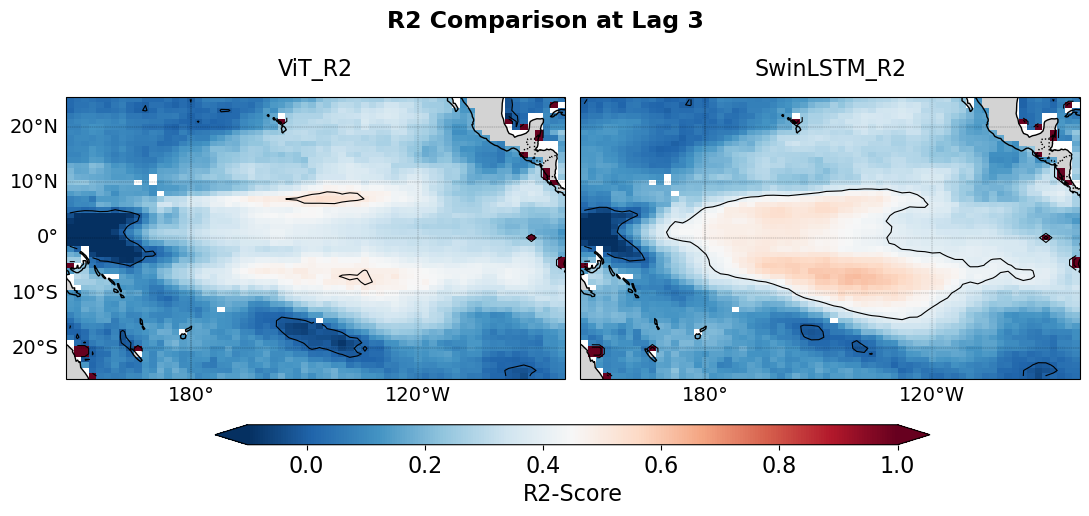

C:\Users\felix\AppData\Local\Temp\ipykernel_22392\4196265576.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.1, 1, 0.93])


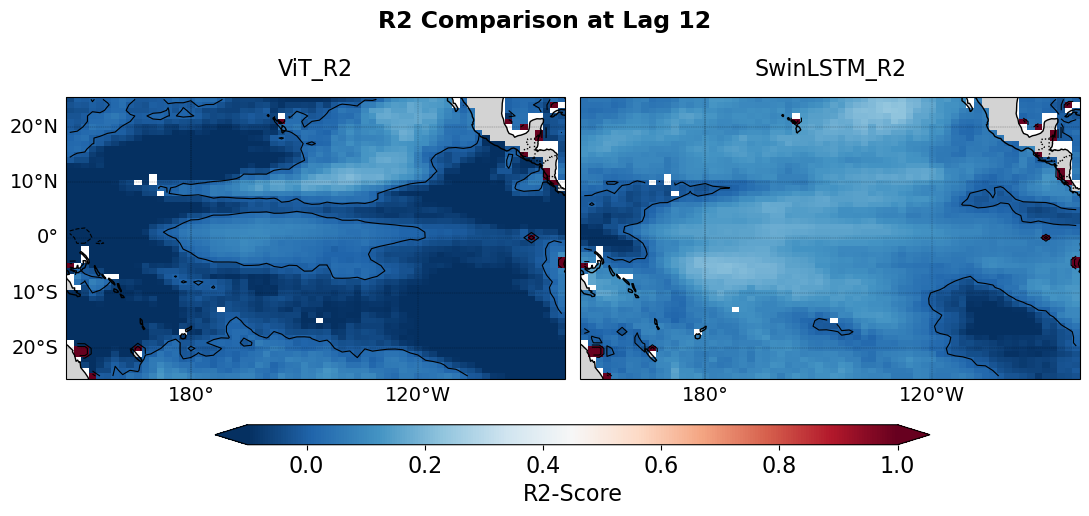

C:\Users\felix\AppData\Local\Temp\ipykernel_22392\4196265576.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.1, 1, 0.93])


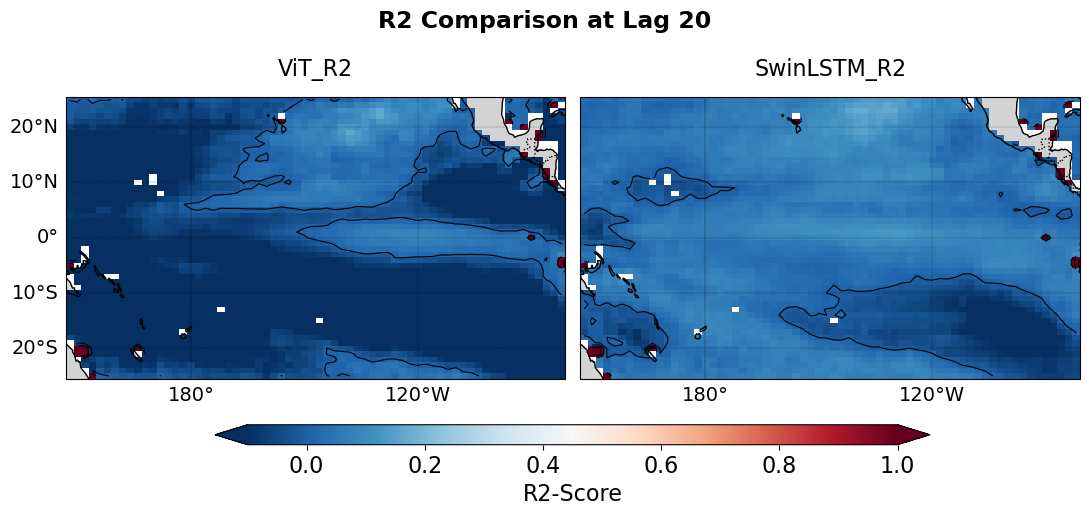

In [309]:
# ===========================================================================================================================
# R2 Spatial Forecast Plot
# ===========================================================================================================================

# Selecting RMSE of 12 month forecast
vit_rmse = data_vit["loss"]["total"]["rmse_orig"]
swinlstm_rmse = data_swinlstm["loss"]["total"]["rmse_orig"]

vit_target_std = data_vit["loss"]["total"]["targ_data_std"]["targets_vit"]
swinlstm_target_std = data_swinlstm["loss"]["total"]["targ_data_std"]["targets_swinlstm"]

vit_r2 = 1 - (vit_rmse[:, :51, :] / vit_target_std[:, :51, 29:95])
swinlstm_r2 = 1 - (swinlstm_rmse[:, :51, :] / swinlstm_target_std[:, :51, 29:95])

lags = [3, 12, 20]

for lag in lags:

    vit_r2_ = vit_r2[lag-1]
    swinlstm_r2_ = swinlstm_r2[lag-1]

    hindcast = dict()
    for key, x in dict(ViT_R2=vit_r2_, SwinLSTM_R2=swinlstm_r2_).items():
        hindcast[key] = xr.DataArray(x, dims=['lat', 'lon'], coords={'lat': val_ds_adapt.lat, 'lon': val_ds_adapt.lon})

    # Create a figure with 2 subplots sharing the same colorbar and projection
    fig, axs = plt.subplots(1, 2, figsize=(11, 5), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180), 'aspect': 'auto'})

    # Define a list of keys, titles, and colorbar parameters
    keys = ['ViT_R2', 'SwinLSTM_R2']
    titles = ['ViT_R2', 'SwinLSTM_R2']
    cmap = 'RdBu_r'
    vmin = -0.1
    vmax = 1

    # Flatten the axes array for easier iteration
    axs = axs.ravel()

    for ax, key, title in zip(axs, keys, titles):
        x = hindcast[key]
        im = ax.pcolormesh(x.lon, x.lat, x, cmap=cmap, vmin=vmin, vmax=vmax, shading='auto', transform=ccrs.PlateCarree())
        ax.coastlines()
        ax.set_title(title, fontsize=16, pad=15)  # Adjusted padding for subplot titles
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        ax.add_feature(cfeature.LAND, facecolor='lightgray')
        gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), linewidth=0.3, color='black', alpha=0.5, linestyle='--')
        gl.top_labels = False  # Remove x-labels from the top
        gl.right_labels = False  # Remove y-labels from the right
        gl.xlabel_style = {'fontsize': 14}  # Increase x-label font size
        gl.ylabel_style = {'fontsize': 14}  # Increase y-label font size
        if ax == axs[1]:  # For the second subplot (right), remove y-labels
            gl.left_labels = False  # Remove y-labels from the left side of the second plot

        # Add contour lines
        ax.contour(x.lon, x.lat, x, levels=2, colors='black', linewidths=0.8, transform=ccrs.PlateCarree())

    # Add a shared colorbar below the plots
    cbar_ax = fig.add_axes([0.2, 0.05, 0.65, 0.04])  # Decreased the space between colorbar and plots
    cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal', extend='both')
    cbar.set_label('R2-Score', fontsize=16)
    cbar.ax.tick_params(labelsize=16)

    # Add a main title for the entire figure
    fig.suptitle(f'R2 Comparison at Lag {lag}', fontsize=17, fontweight='bold', y=0.92)  # Adjusted to bring suptitle closer to plots

    # Improve layout, reduce space around plots and suptitle
    plt.tight_layout(rect=[0, 0.1, 1, 0.93])
    
    plt.show()
    fig.savefig(f'{save_dir}/r2_comparison_lag_{lag}.png')

C:\Users\felix\AppData\Local\Temp\ipykernel_22392\3129481130.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.1, 1, 0.93])


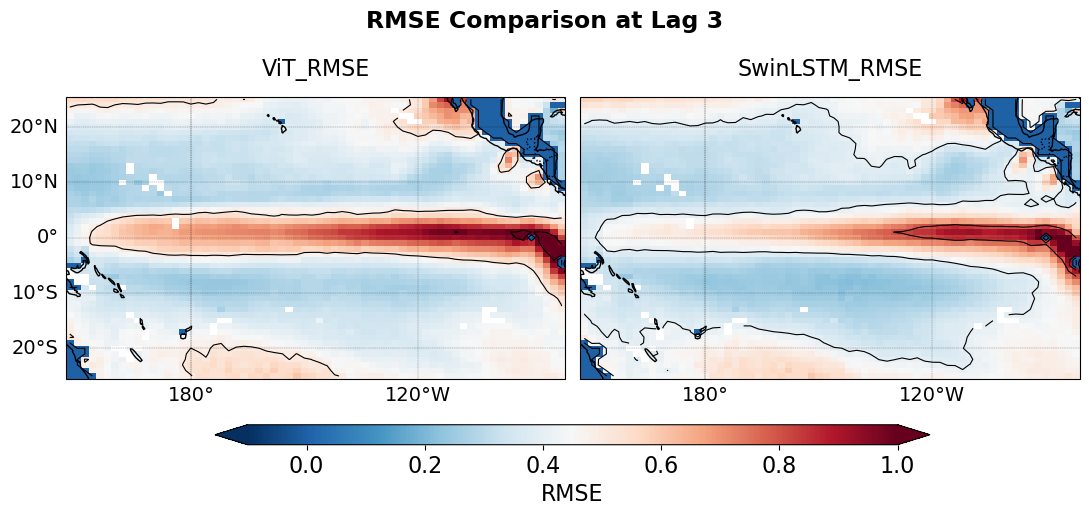

C:\Users\felix\AppData\Local\Temp\ipykernel_22392\3129481130.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.1, 1, 0.93])


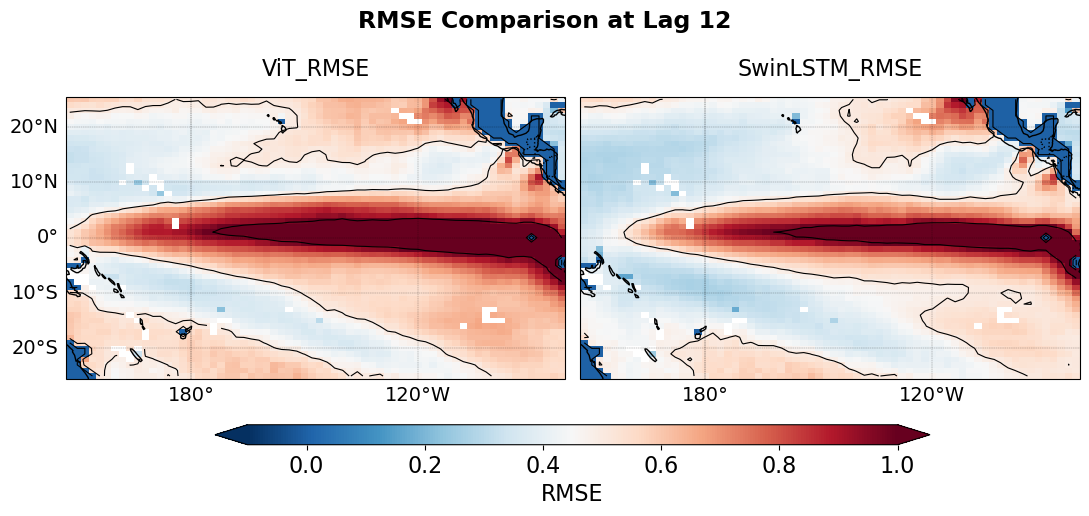

C:\Users\felix\AppData\Local\Temp\ipykernel_22392\3129481130.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.1, 1, 0.93])


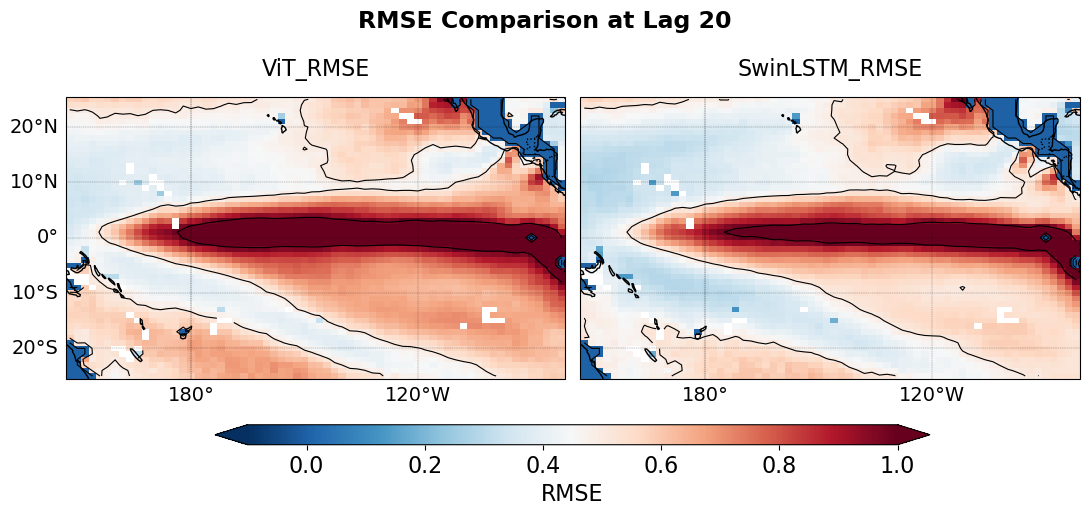

In [310]:
# ===========================================================================================================================
# RMSE Spatial Forecast Plot
# ===========================================================================================================================


# Selecting RMSE of 12 month forecast
vit_rmse = data_vit["loss"]["total"]["rmse_orig"]
swinlstm_rmse = data_swinlstm["loss"]["total"]["rmse_orig"]

lags = [3, 12, 20]

for lag in lags:

    vit_rmse_ = vit_rmse[lag-1]
    swinlstm_rmse_ = swinlstm_rmse[lag-1]

    hindcast = dict()
    for key, x in dict(ViT_RMSE=vit_rmse_, SwinLSTM_RMSE=swinlstm_rmse_).items():
    
        x_lst = []
        da = xr.DataArray(
            data=x[:51, :],
            coords=val_ds_adapt.isel(time=0).coords)
        # Mask land
        da = da.where(lsm == 0, other=np.nan)
        hindcast[key] = da

    # Create a figure with 2 subplots sharing the same colorbar and projection
    fig, axs = plt.subplots(1, 2, figsize=(11, 5), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180), 'aspect': 'auto'})

    # Define a list of keys, titles, and colorbar parameters
    keys = ['ViT_RMSE', 'SwinLSTM_RMSE']
    titles = ['ViT_RMSE', 'SwinLSTM_RMSE']
    cmap = 'RdBu_r'
    vmin = -0.1
    vmax = 1

    # Flatten the axes array for easier iteration
    axs = axs.ravel()

    for ax, key, title in zip(axs, keys, titles):
        x = hindcast[key]
        im = ax.pcolormesh(x.lon, x.lat, x, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
        ax.coastlines()
        ax.set_title(title, fontsize=16, pad=15)  # Adjusted padding for subplot titles
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        ax.add_feature(cfeature.LAND, facecolor='lightgray')
        gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), linewidth=0.3, color='black', alpha=0.5, linestyle='--')
        gl.top_labels = False  # Remove x-labels from the top
        gl.right_labels = False  # Remove y-labels from the right
        gl.xlabel_style = {'fontsize': 14}  # Increase x-label font size
        gl.ylabel_style = {'fontsize': 14}  # Increase y-label font size
        if ax == axs[1]:  # For the second subplot (right), remove y-labels
            gl.left_labels = False  # Remove y-labels from the left side of the second plot

        # Add contour lines
        ax.contour(x.lon, x.lat, x, levels=2, colors='black', linewidths=0.8, transform=ccrs.PlateCarree())

    # Add a shared colorbar below the plots
    cbar_ax = fig.add_axes([0.2, 0.05, 0.65, 0.04])  # Decreased the space between colorbar and plots
    cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal', extend='both')
    cbar.set_label('RMSE', fontsize=16)
    cbar.ax.tick_params(labelsize=16)

    # Add a main title for the entire figure
    fig.suptitle(f'RMSE Comparison at Lag {lag}', fontsize=17, fontweight='bold', y=0.92)  # Adjusted to bring suptitle closer to plots

    # Improve layout, reduce space around plots and suptitle
    plt.tight_layout(rect=[0, 0.1, 1, 0.93])
    
    plt.show()
    fig.savefig(f'{save_dir}/rmse_comparison_lag_{lag}.png')

In [311]:
prediction = data_vit["predictions"][0][0]
context = data_vit["predictions"][0][1]
target = data_vit["targets"][0][0]
model_name = "ViT"

#select batch that starts prediction in january -> takes full year as input and predicts 20 months
prediction = prediction[4, :, :, :]
context = context[4, :,]
target = target[4, :, :, :]

# Select Nino 3, 3.4, and 4 regions
nino_indices = []
nino_3_lat = (21, 31)
nino_3_lon = (62, 122)
nino_34_lon = (42, 92)
nino_4_lon = (12, 62)
nino_indices.append([0, 0, ""])
#nino_indices.append([nino_3_lat, nino_3_lon, "_Nino3"])
#nino_indices.append([nino_3_lat, nino_34_lon, "_Nino34"])
#nino_indices.append([nino_3_lat, nino_4_lon, "_Nino4"])

for indice in nino_indices:

    if indice[0]==0:
        pass
    else:
        prediction = prediction[:, indice[0][0]:indice[0][1], indice[1][0]:indice[1][1]]
        target = target[:, indice[0][0]:indice[0][1], indice[1][0]:indice[1][1]]

    # Average over dimensions 1 and 2 (spatial dimensions)
    prediction_avg = prediction.mean(dim=(1, 2)).numpy()  # Shape: [20]
    target_avg = target.mean(dim=(1, 2)).numpy()  # Shape: [20]

    # Define months labels assuming a 1-year cycle (12 months)
    months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

    # Repeat the month labels to match the length of the time series
    # Slice it to match the exact number of time steps
    month_labels = (months * ((len(prediction_avg) // 12) + 1))[:len(prediction_avg)]

    # Select only every second month for display
    xticks_positions = np.arange(0, len(prediction_avg), 2)
    xticks_labels = month_labels[::2]

    # Plotting the time series
    plt.figure(figsize=(12, 6))

    # Plot Prediction
    plt.plot(prediction_avg, label=f'Prediction{indice[2]}', color='#1f77b4', linewidth=2.5, linestyle='-', marker='o')

    # Plot Target
    plt.plot(target_avg, label=f'Target{indice[2]}', color='#ff7f0e', linewidth=2.5, linestyle='--', marker='s')

    # Adding a grid
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    # Title and labels
    plt.title('Time Series of Averaged Sea Surface Temperature (SST) at Level 0 - ENSO', fontsize=16, fontweight='bold')
    plt.xlabel('Months', fontsize=14)
    plt.ylabel('Averaged SST [°C]', fontsize=14)

    # Set x-ticks to display every second month
    plt.xticks(ticks=xticks_positions, labels=xticks_labels, fontsize=12)

    # Adding a legend
    plt.legend(fontsize=12)

    # Improving layout
    plt.tight_layout()

    # Show the plot
    plt.show()
    fig.savefig(f'C:/Users/felix/PycharmProjects/deeps2a-enso/scripts/picontrol/evaluation/evaluation_results/{save_dir}/timeseries_{model_name}.png')

KeyError: 'predictions'